# Social Media Mining: Cross-Validation
### Vincent Malic - Spring 2018
## Module 5.1 Cross-Validation

## Selecting model hyperparameters
* Goal of statistical learning is to build models that **generalize well**
* Split Iris dataset into train / test sets; use kNN classifier to predict Iris species
* Select best value of ``k`` based on plot of accuracy of different models

### CAUTION about select parameters
* Choosing parameter values based on training set may lead to overfitting
* Test set should *only* be used to evaluate performance of final model 

## Solution 1:  Training, Validation, and Test sets 
1. Split your data into training and testing data. Set the testing data aside, don't look at it until you're ready for a final evaluation. 
2. Split your *training* data into two sets: (a) Train on one, (b) evaluate model and adjust hyperparameters accordingly. 

### Validation set
* https://en.wikipedia.org/wiki/Test_set#Validation_set 
* Use validation set to find the best hyperparameters according to performance on the validation set. 
* Researchers use 60/20/20 split: 60% training, 20% validatation, 20% test set. 

## Solution 2: K-Fold Cross Validation
* Repeatedly sample your dataset, drawing off subsets of size k for validation:

1. Randomly split your data, designating one piece as testing data. Set that aside. 
2. Shuffle the remaining (non-testing) data. 
3. Divide it into k equally-sized sets. Let's say in our case k is 10. We call these equally sized sets **folds**. 
4. Let the first 9 folds be the training set, and the 10th be the validation set. Train on the first 9 folds and get an evaluation metric like accuracy on the 10th. 
5. Then, let the 9th fold be the validation set. Train on folds 1-8 and 10, evaluate on the 9th. 
6. Then, let the 8th fold be the validation set. Train on sets 1-7 and 9-10, evaluate on the 8th. 
7. And so on, until you run out of folds. 
8. When your done, you have 10 accuracy values, one for each fold. Calculate the average of those accuracies and you have an idea of how your model performs on 10 different validation sets. 

#### Visualization of the 10-fold cross validation: 

<img src="http://ella.ils.indiana.edu/~vmalic/z639/10_fold_cv.png">

### How does this work? 
* With one validation set, we might overfit to the validation set. 
* By performing k-fold cross validation, we get multiple accuracies. 
* Take the average of multiple model accuracies for k-1 datasets. 

## Choosing K-folds (not neighbors)
Consider number of samples in dataset:
* For 1000-fold CV, each validation set will have small amount of data, accuracies may vary quite a bit. 
* 2-fold CV will have many samples in validation set, but only get two accuracies. 
* 5-fold or 10-fold CV commonly used. 

# K-fold Cross Validation in Scikit-Learn
* Train kNN classifier Iris data, using ``k=5``. 
* Spllit data into 67/33 train test sets
* With 150 samples, test set of 50. 

In [1]:
import numpy as np

np.random.seed(3057)

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)
print(X_train.shape)
print(X_test.shape)

(100, 4)
(50, 4)


### Initialize Nearest Neighbor Classifier.

In [2]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5)

### Import ``cross_val_score``  function from sklearn 
Five parameters for ``cross_val_score``
1. The untrained model. In our case, this is the variable ``clf``.
2. The training data, ``X_train``. ``cross_val_score`` will generate the validation sets automatically.
3. The training labels, ``y_train``. 
4. A parameter called ``scoring`` which takes a string as its value. This indicates *what kind of metric* you want to use. The string `accuracy` uses accuracy. The string ``r2`` will calculate R-squared for regression problems. A full list of strings for metrics you can use can be [found here](http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values). 
5. A parameter called ``cv`` indicating the number of folds. 

### Perform 10-fold cross validation on Training data. 
* I'm going to use accuracy as the scoring metric (but I could use F1 scores or recall or whatever if I wanted).
* ``cross_val_score`` teturns a list that is the same length as the parameter ``cv``. 
* Lists the evaluation metric obtained for each fold.

In [3]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=10)
print(cv_scores)

[ 1.          1.          1.          0.8         0.88888889  0.88888889
  1.          0.88888889  1.          1.        ]


### Take average of the Validation sets.
* Some models did well, and some didn't do as well. 
* Composite score gives indication of how well classifier did over all folds:
* Overall, we have pretty high score for ``k=5`` folds CV 

In [4]:
print(np.mean(cv_scores))

0.946666666667


# Use k-fold CV for Hyperparameter Optimization
* Original problem: Find optimal value for ``k``?
* First select a set of candidate values for ``k``. 
* E.g., every odd number from 1 to 50. 

In [5]:
k_candidates = np.arange(1, 50, 2)

## For *each hyperparameter candidate*
* Run k-fold cross validation, using 10 folds for this example.  
* Get and save the average accuracy attained during each CV. 
* Hyperparameter with highest average accuracy is optimal value for k. 

### Finally, using only that value of ``k``, 
* Evaluate on the held-out test data. 
* This is final accuracy you report to your boss or in research paper. 
* Do this using scikit-learn:

In [6]:
average_accuracies = []

for k in k_candidates:
    clf = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(clf, X_train, y_train, scoring="accuracy", cv=10)
    average_accuracy = np.mean(cv_scores)
    average_accuracies.append(average_accuracy)

### Explore average accuracies for value of k using visualization.

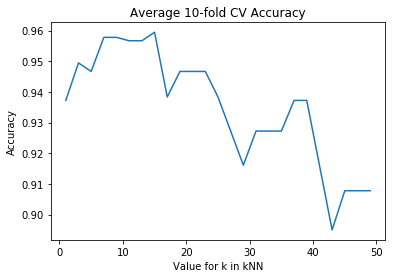

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

plt.plot(k_candidates, average_accuracies)
plt.title("Average 10-fold CV Accuracy")
plt.xlabel("Value for k in kNN")
plt.ylabel("Accuracy")

plt.show()

### Optimal performance is between 5 and 20
* Best value we achieved was at ``k=15``, with an accuracy of 96%.
* Train our final classifier on all Training data with ``k=15``
* See how well it performs on the held-out test data. 

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

clf = KNeighborsClassifier(n_neighbors=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Final Test Set Accuracy:")
print(accuracy_score(y_test, y_pred))

Final Test Set Accuracy:
0.98


### 15-NN model generalized quite well
* Cross-validation determined the best value of k
* We are certain that the test data is truly unseen data. 

## Confusion Matrix:

In [10]:
confusion_matrix(y_test, y_pred)

array([[17,  0,  0],
       [ 0, 16,  1],
       [ 0,  0, 16]])

### Evaluate Model on Test Set
* Of 50 test samples, every one was classified correctly, except for one 
* A single instance of *Versicolor* erroneously classified as *Virginica*. 


## Use k-fold CV for different models (not just kNN)
* Cross validation can be used to optimize *any* model that uses hyperparameters. 

### Hyperparameter ``C`` in SVM:  
* Generate some candidates for ``C`` and find k-fold CV accuracies for each value. 
* Choose a value for ``C`` that gets the highest accuracy.

### Non-numeric Hyperparameter in SVM: 
* Use k-fold CV with type of kernel (e.g., linear, rbf, or poly). 
* Same principle applies: Do k-fold CV for each of the kernels
* Find value that has the best average accuracy.